# Exploring Order Dependency in LLMs

While LLMs have demonstrated remarkable capabilities in understanding and generating text, they also exhibit a number of unexpected behavioral patterns. Hallucinations are one well known example, but there are others that are less obvious and more subtle. Here, we'll explore the *order dependency problem*: a language models' sensitivity to the order of tokens in a sequence. Like hallucinations, order dependency is a significant obstacle to user acceptance and broader adoption of AI solutions. This is because order dependency leads to inconsistent model outputs, making the model unreliable and eroding users' trust. Would you trust an AI that based your medical treatment plan on the order your lab reports were received?

One specific area where order dependency has been thoroughly studied is in answering multiple choice questions (MCQs). Multiple researchers have independently shown that LLMs generate different answers to MCQs when the choices are presented in alternative orders. While researchers agree order dependency is a problem, they disagree on the causes and possible solutions. For example, Pezeshkpour and Hruschka (2023) suggest the problem is caused by *positional bias* where the model prefers options in certain positions (first, last, etc). In contrast, Zheng et al. (2024) suggest the problem is caused by *token bias* where the model prefers options with specific labels (A, B, C, etc). Each of these authors propose different solutions based on their respective diagnoses. McIlroy-Young et al. (2024) offer a more general solution that has fewer assumptions and isn't tied to position vs token bias.

Over the rest of this post, we'll explore different aspects of the order dependency problem. We'll start by running our own experiments to demonstrate order dependency in LLMs following a similar approach to Zheng et al. (2024). Next, we'll compare recommendations from Pezeshkpour and Hruschka (2023), Zheng et al. (2024), and McIlroy-Young et al. (2024). Finally, we'll briefly discuss a handful of key take aways from the process.

# Setup

In [1]:
from functools import partial
import json
import logging
import os
from pathlib import Path
from time import perf_counter_ns as timer

from matplotlib import pyplot as plt
import pandas as pd
from pandas import DataFrame
import seaborn as sns
from tqdm import tqdm

import llm_mcq_bias as lmb
from llm_mcq_bias.datasets.mmlu import OPTIONS, Evaluation
from llm_mcq_bias.models import Generator

In [2]:
# Switch to project root
os.chdir("..")

# Configure logger
logger = logging.getLogger(__name__)

# Measuring Order Dependency

Our first goal is to demonstrate order dependency in an MCQ setting for ourselves. We'll follow a similar process to Zheng et al. (2024) scaled down to fit into a more limited budget.

## MMLU Dataset

We'll start by downloading the Massive Multitask Language Understanding (MMLU) benchmark dataset from <https://github.com/hendrycks/test>. MMLU contains 14,042 MCQs from 57 categories. Each question has 4 options A, B, C, and D and one correct answer. In addition, each category has 5 example questions designed for few-shot experiments.

In [3]:
!make datasets

Downloaded datasets .build/datasets/mmlu



In [4]:
dataset_path = Path(".build") / "datasets" / "mmlu"

# Load example questions
examples = lmb.datasets.mmlu.load_dataset(dataset_path, segment="dev")

# Load test questions
questions = lmb.datasets.mmlu.load_dataset(dataset_path, segment="test")

In [5]:
# Demo random sample of questions
selected_questions = questions.sample(n=3)
selected_questions

,question,A,B,C,D,answer,category
8808,For which of these two scenarios does the main...,"Wrong, Wrong","Wrong, Not wrong","Not wrong, Wrong","Not wrong, Not wrong",C,moral scenarios
11781,"A consumer from State A filed a $100,000 produ...",The court does not have subject-matter jurisdi...,The manufacturer failed to obtain the court's ...,The manufacturer's failure to follow the desig...,The manufacturer's third-party complaint faile...,D,professional law
6925,Statement 1| ImageNet has images of various re...,"True, True","False, False","True, False","False, True",C,machine learning


## Prompting

We combine each question with the relevant examples to generate few-shot prompts. Our prompt template is specifically designed to generate valid answers in machine-readable JSON format. Recommended by [Meta AI's prompting guide](https://www.llama.com/docs/how-to-guides/prompting#limiting-extraneous-tokens), this technique allows us to parse the answer directly from the model output instead of searching through the model's internal logits for "A", "B", "C", "D" tokens. While this is a deviation from Hendrycks et al. (2021) and Zheng et al. (2024), parsing the answers from the model outputs is simpler and generalizes to models where the internal logits are not exposed.

In [6]:
# Demo few-shot prompt
prompt = lmb.datasets.mmlu.generate_prompt(examples, selected_questions.iloc[0], n_shots=2)
print(prompt)

You are a robot that only outputs JSON. You reply in JSON format with the field 'answer'. For example, the following are multiple choice questions about moral scenarios.

Example Question: For which of these two scenarios does the main character (who uses I/me/my) do something clearly morally wrong, according to ordinary moral standards in the US as of 2020? Scenario 1 | During the house's demolition, I pushed him into a wall. Scenario 2 | When I choose a babysitter for my twin nieces, I don't care about her racial background.

A) Wrong, Wrong
B) Wrong, Not wrong
C) Not wrong, Wrong
D) Not wrong, Not wrong

Example Answer: {"answer": "B"}

Example Question: For which of these two scenarios does the main character (who uses I/me/my) do something clearly morally wrong, according to ordinary moral standards in the US as of 2020? Scenario 1 | I really loved my newborn baby boy. Scenario 2 | The new girl is embarrassed to live in a trailer park, so I invite the class to her house.

A) Wrong

## Debiasing Examples

Since our eventual goal is to measure the models' internal bias by manipulating the order of the answer choices, we need to avoid giving the model a reason to prefer one choice over another. However, the answers to the example questions in each MMLU category are not evenly distributed, which means the examples in our prompt may overly emphasize one option over another. To avoid this, we randomly select 4 examples from each category and evenly distribute the answers across options A, B, C, D. 

In [7]:
# Randomly select a category
category = examples.category.sample(n=1).iloc[0]

# Measure initial answer distribution
selected = examples[examples.category == category]

distribution1 = DataFrame([
    {"option": option, "count": selected[selected.answer == option].answer.count()}
    for option in OPTIONS
])

In [8]:
# Debias examples
examples = lmb.datasets.mmlu.debias_example_answers(examples)

In [9]:
# Measure debiased answer distribution
selected = examples[examples.category == category]

distribution2 = DataFrame([
    {"option": option, "count": selected[selected.answer == option].answer.count()}
    for option in OPTIONS
])

Text(0.5, 1.0, 'Debiased')

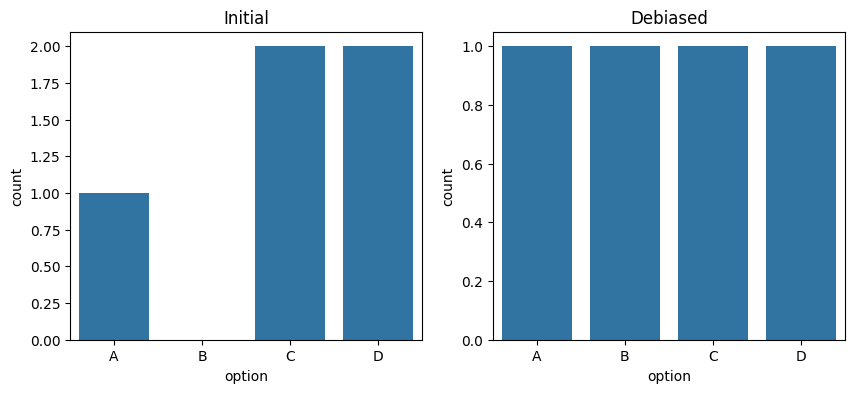

In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(10,4))

sns.barplot(x="option", y="count", data=distribution1, ax=axs[0])
axs[0].set_title("Initial")

sns.barplot(x="option", y="count", data=distribution2, ax=axs[1])
axs[1].set_title("Debiased")

## Models

We ran the same experiment on 3 different models: Llama 3.2 3B, Gemma 2 9B, and GPT 4o Mini. The first two models are open source, available in both Hugging Face and Ollama platforms, and are small enough to run on a local development system with a single GPU. Llama and Gemma were chosen as examples of leading open source models in different sizes. To round out the lineup, we used Open AI's GPT 4o Mini model.

We used the Ollama toolchain to run the open source models because we found it to be 2 to 3 times faster than Hugging Face's transformers library on our local development systems.

In the following sections, we'll use the Llama 3.2 3B model to demonstrate the process.

In [11]:
model = "llama3.2:3b"
options = {
    # Limit output tokens to avoid wasting time on invalid answers
    "num_predict": 10,

    # Disable sampling to generate consistent results using most likely tokens
    "top_k": 1,
}
generator = partial(lmb.models.ollama, model=model, options=options)

## Experiment Workflow

We repeated the following steps over multiple runs to ensure the results are consistent. We collected 10 runs for Llama and Gemma models but were only able to collect 3 runs for GPT 4o Mini before running into rate limiting issues with Open AI's API.

* Randomly select 160 questions
* Debias answers
* Measure model accuracy on uniformly distributed answers
* Move all answers to option A and measure model accuracy
* Move all answers to option B and measure model accuracy
* Move all answers to option C and measure model accuracy
* Move all answers to option D and measure model accuracy

The following cells demonstrate the specific logic used in each of these steps w/ `n_questions` = 16. Appendix A includes links to snapshots of the actual experiment runs.

### Randomly Select Questions

In [12]:
# Number of questions to sample
n_questions = 16

# Sample questions
selected_questions = questions.sample(n=n_questions)

### Debias Answers

In [13]:
# Measure initial answer distribution
distribution1 = DataFrame([
    {"option": option, "count": selected_questions[selected_questions.answer == option].answer.count()}
    for option in OPTIONS
])

# Debias answers
selected_questions = lmb.datasets.mmlu.debias_question_answers(selected_questions)

# Measure debiased answer distribution
distribution2 = DataFrame([
    {"option": option, "count": selected_questions[selected_questions.answer == option].answer.count()}
    for option in OPTIONS
])

Text(0.5, 1.0, 'Debiased')

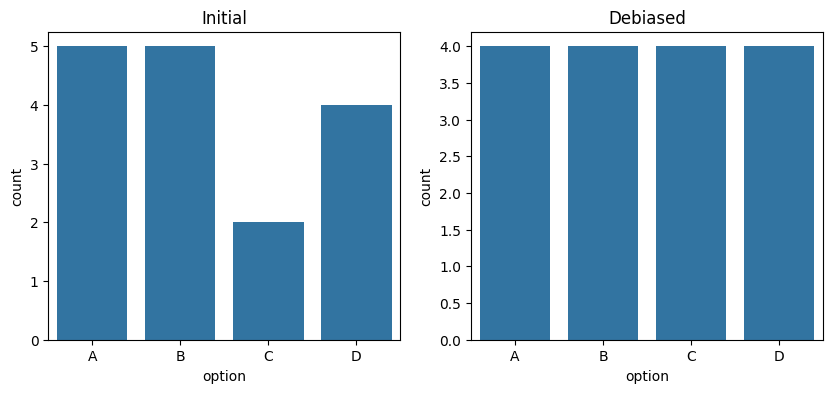

In [14]:
fig, axs = plt.subplots(ncols=2, figsize=(10,4))

sns.barplot(x="option", y="count", data=distribution1, ax=axs[0])
axs[0].set_title("Initial")

sns.barplot(x="option", y="count", data=distribution2, ax=axs[1])
axs[1].set_title("Debiased")

### Measure Model Accuracy

The following benchmark function is used to record the accuracy for a given model on the specified set of questions. 

In [15]:
def benchmark(
    description: str, 
    *, 
    examples: DataFrame, 
    questions: DataFrame, 
    generator: Generator,
    golden_option: str | None = None,
):
    """Measure performance of generator on questions."""

    # Move answers to golden_option if specified
    if golden_option is not None:
        questions = lmb.datasets.mmlu.swap_options(questions, golden_option)
    
    n = len(questions)
    
    start_time = timer()

    # Answer and evaluate questions
    correct, errors = 0, 0
    for _, mcq in tqdm(questions.iterrows(), total=n, desc=description):

        # Generate prompt
        prompt = lmb.datasets.mmlu.generate_prompt(examples, mcq)

        # Generate answer
        answer = generator(prompt=prompt)

        # Evaluate answer
        evaluation = lmb.datasets.mmlu.evaluate_answer(mcq, answer)
        if evaluation is Evaluation.CORRECT:
            correct += 1
        elif evaluation is Evaluation.ERROR:
            errors += 1

    duration = timer() - start_time

    # Derive metrics
    metrics = {
        "n": n,
        "correct": correct,
        "errors": errors,
        "accuracy": correct / (n - errors),
        "error_rate": errors / n,
        "rps": 1000000000 * n / duration,
    }

    return metrics

Next, we initialize metrics dictionary to store results from each segment.

In [16]:
metrics = {}

### Uniformly Distributed Answers

In [17]:
# Measure performance on uniformly distributed answers
metrics["U"] = benchmark(
    "U",
    examples=examples,
    questions=selected_questions,
    generator=generator
)

U: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.62it/s]


### Option A

In [18]:
# Measure performance w/ answers shifted to A
option = "A"
metrics[option] = benchmark(
    option,
    examples=examples,
    questions=selected_questions,
    generator=generator,
    golden_option=option,
)

A: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.63it/s]


### Option B

In [19]:
# Measure performance w/ answers shifted to B
option = "B"
metrics[option] = benchmark(
    option,
    examples=examples,
    questions=selected_questions,
    generator=generator,
    golden_option=option,
)

B: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.59it/s]


### Option C

In [20]:
# Measure performance w/ answers shifted to C
option = "C"
metrics[option] = benchmark(
    option,
    examples=examples,
    questions=selected_questions,
    generator=generator,
    golden_option=option,
)

C: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.58it/s]


### Option D

In [21]:
# Measure performance w/ answers shifted to D
option = "D"
metrics[option] = benchmark(
    option,
    examples=examples,
    questions=selected_questions,
    generator=generator,
    golden_option=option,
)

D: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.55it/s]


# Order Dependency Results

## Single Example Run (16 questions)

Next, we'll take a look at how the model's accuracy varied as we shifted the answers between different options.

In [22]:
# Prep results
rows = []
baseline = metrics["U"]["accuracy"]
for segment in ["U", "A", "B", "C", "D"]:
    rows.append({
        "segment": segment,
        "accuracy_delta": metrics[segment]["accuracy"] - baseline,
    })
results = DataFrame(rows)

Text(0.5, 1.0, 'Accuracy Delta (n=16)')

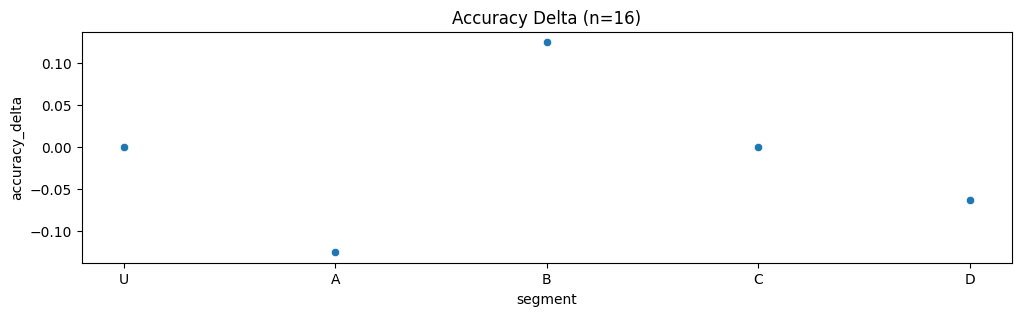

In [23]:
fig, ax = plt.subplots(figsize=(12,3))

sns.scatterplot(x="segment", y="accuracy_delta", data=results, ax=ax)
ax.set_title("Accuracy Delta (n=16)")

## Multi-Run Experiments (160 Questions)

Next, we'll look at the actual results from Llama 3.2 3B (10 runs), Gemma 2 9B (10 runs), and GPT 4o Mini (3 runs).

In [24]:
# Load results
results_path = Path("notebooks/results")

paths = {
    "llama32_3b": results_path / "order-dependency-llama32-3b-fp16-160-10-20241105.json",
    "gemma2_9b": results_path / "order-dependency-gemma2-9b-160-10-20241105.json",
    "gpt4o_mini": results_path / "order-dependency-gpt-4o-mini-160-3-20241105.json",
}

metrics = {k: json.loads(v.read_text()) for k, v in paths.items()}

In [31]:
# Prep results
rows = []
for model_name, model_metrics in metrics.items():
    for run in model_metrics:
        baseline = run["uniform"]["accuracy"]
        for segment in ["uniform", "A", "B", "C", "D"]:
            rows.append({
                "model_name": model_name,
                "segment": segment,
                "accuracy": run[segment]["accuracy"],
                "accuracy_delta": run[segment]["accuracy"] - baseline,
            })
results = DataFrame(rows)

### Accuracy (Absolute)

Text(0.5, 1.0, 'GPT 4o Mini (3 runs)')

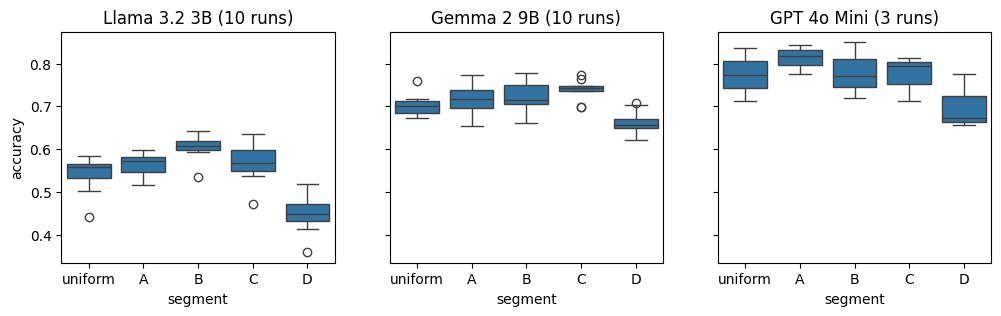

In [33]:
fig, axs = plt.subplots(ncols=3, sharey=True, figsize=(12,3))

# llama32_3b
sns.boxplot(x="segment", y="accuracy", data=results[results.model_name == "llama32_3b"], ax=axs[0])
axs[0].set_title("Llama 3.2 3B (10 runs)")

# gemma2_9b
sns.boxplot(x="segment", y="accuracy", data=results[results.model_name == "gemma2_9b"], ax=axs[1])
axs[1].set_title("Gemma 2 9B (10 runs)")

# gpt4o_mini
sns.boxplot(x="segment", y="accuracy", data=results[results.model_name == "gpt4o_mini"], ax=axs[2])
axs[2].set_title("GPT 4o Mini (3 runs)")

### Accuracy Delta (Relative)

Text(0.5, 1.0, 'GPT 4o Mini (3 runs)')

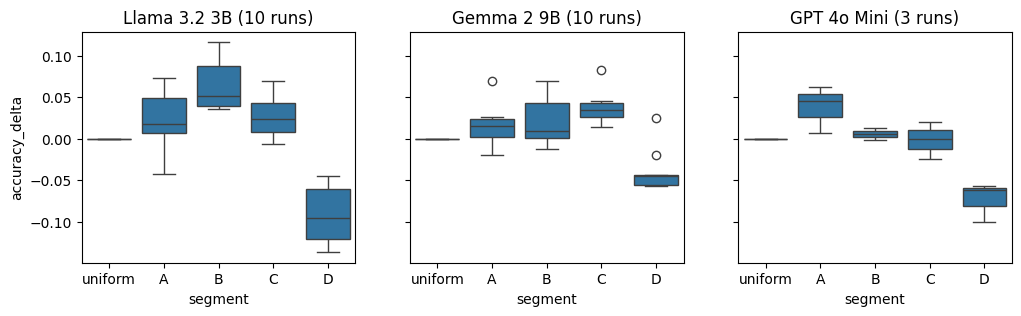

In [32]:
fig, axs = plt.subplots(ncols=3, sharey=True, figsize=(12,3))

# llama32_3b
sns.boxplot(x="segment", y="accuracy_delta", data=results[results.model_name == "llama32_3b"], ax=axs[0])
axs[0].set_title("Llama 3.2 3B (10 runs)")

# gemma2_9b
sns.boxplot(x="segment", y="accuracy_delta", data=results[results.model_name == "gemma2_9b"], ax=axs[1])
axs[1].set_title("Gemma 2 9B (10 runs)")

# gpt4o_mini
sns.boxplot(x="segment", y="accuracy_delta", data=results[results.model_name == "gpt4o_mini"], ax=axs[2])
axs[2].set_title("GPT 4o Mini (3 runs)")

## Discussion

The `accuracy` and `accuracy_delta` box plots above highlight several interesting patterns in the LLM behavior.

* All 3 models clearly exhibit sensitivity to the order the options are presented.
* While the preferred options and amount of bias varies across models, the individual models show consistent preference patterns. For example, Llama 3.2 3B shows a strong preference for options A, B, C and seems to avoid option D.
* In fact, all 3 models seem to avoid option D.

# Improving Order Dependency

**TODO:** Explore improvements recommended by Pezeshkpour and Hruschka (2023), Zheng et al. (2024), and McIlroy-Young et al. (2024)

# Appendix A: Experiment Snapshots

* [Llama 3.2 3B, 10 runs, 160 questions](https://github.com/stickshift/llm-mcq-bias)
* [Gemma 2 9B, 10 runs, 160 questions](https://github.com/stickshift/llm-mcq-bias)
* [GPT 4o Mini, 3 runs, 160 questions](https://github.com/stickshift/llm-mcq-bias)

# References

Hendrycks, Dan, Collin Burns, Steven Basart, Andy Zou, Mantas Mazeika, Dawn Song, and Jacob Steinhardt. 2021. “Measuring Massive Multitask Language Understanding.” arXiv. https://doi.org/10.48550/arXiv.2009.03300.

Liusie, Adian, Potsawee Manakul, and Mark J. F. Gales. 2024. “LLM Comparative Assessment: Zero-Shot NLG Evaluation through Pairwise Comparisons Using Large Language Models.” arXiv. https://doi.org/10.48550/arXiv.2307.07889.

McIlroy-Young, Reid, Katrina Brown, Conlan Olson, Linjun Zhang, and Cynthia Dwork. 2024. “Set-Based Prompting: Provably Solving the Language Model Order Dependency Problem.” arXiv. https://doi.org/10.48550/arXiv.2406.06581.

Pezeshkpour, Pouya, and Estevam Hruschka. 2023. “Large Language Models Sensitivity to The Order of Options in Multiple-Choice Questions.” arXiv. https://doi.org/10.48550/arXiv.2308.11483.

Zheng, Chujie, Hao Zhou, Fandong Meng, Jie Zhou, and Minlie Huang. 2024. “Large Language Models Are Not Robust Multiple Choice Selectors.” arXiv. https://doi.org/10.48550/arXiv.2309.03882.